<a href="https://colab.research.google.com/github/theoVasilas/NN_training/blob/main/MINIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dowload dataset and imports

In [1]:
%%capture
%pip install torch
%pip install torchvision
#captured_output.show()

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.utils import io
import numpy as np


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:11<00:00, 894kB/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.56MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(train_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## tranforms


In [6]:
from torchvision import transforms

transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = False,
    transform = transform_train
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = False,
    transform=transform_test
)

## loaders

In [7]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'valid' : torch.utils.data.DataLoader(val_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1)
}


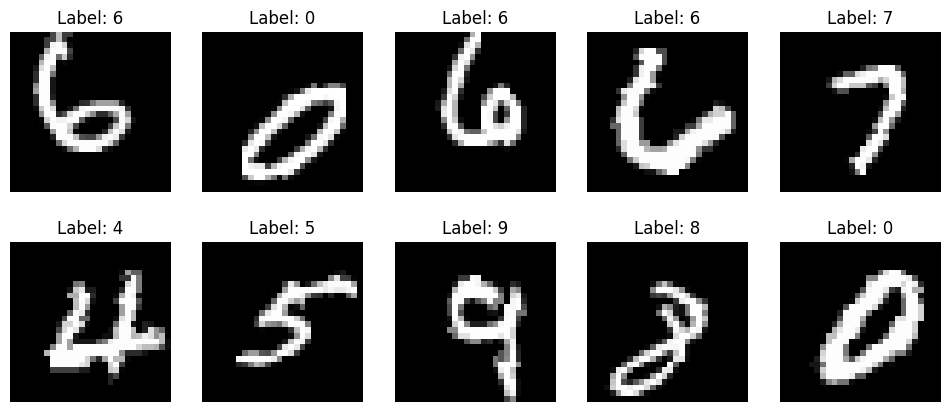

In [8]:
train_loader = loaders['train']
data_iter = iter(train_loader)

# Plot 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(10):
    images, labels = next(data_iter)
    ax = axes[i // 5, i % 5]
    ax.imshow(images[0].permute(1, 2, 0).squeeze(), cmap='gray')  # Assuming images are in CHW format
    ax.set_title(f"Label: {labels[0]}")
    ax.axis('off')

plt.show()

## Simple CNN

In [9]:
import torch.nn as nn
class Simple_CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


model = Simple_CNN()

## My_CNN

In [25]:
class My_Net(nn.Module):
    def __init__(self, num_classes):
        super(My_Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.Dropout2d(p=0.1)
        )


        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=24,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=32,
                kernel_size=2,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.3)

        )

        self.linear1 = nn.Linear(in_features=32 * 7 * 7, out_features=24)

        self.drop = nn.Dropout(p=0.3)

        self.linear2 = nn.Linear(in_features=24, out_features=num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten
        x = x.view(-1, 32 * 7 * 7)

        x = self.linear1(x)
        x = nn.functional.relu(x)

        x = self.drop(x)

        x = self.linear2(x)

        output = torch.log_softmax(x, dim=1)
        return output

model = My_Net(num_classes=10).to(device)

print(model)


My_Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (linear1): Linear(in_features=1568, out_features=24, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (linear2): Linear(in_features=24, out_features=10, bias=True)
)


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=edec4ddfa7d9173722db2d2fa68b63072403a9b29eec3ffcefbc5189aaa03d3b
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


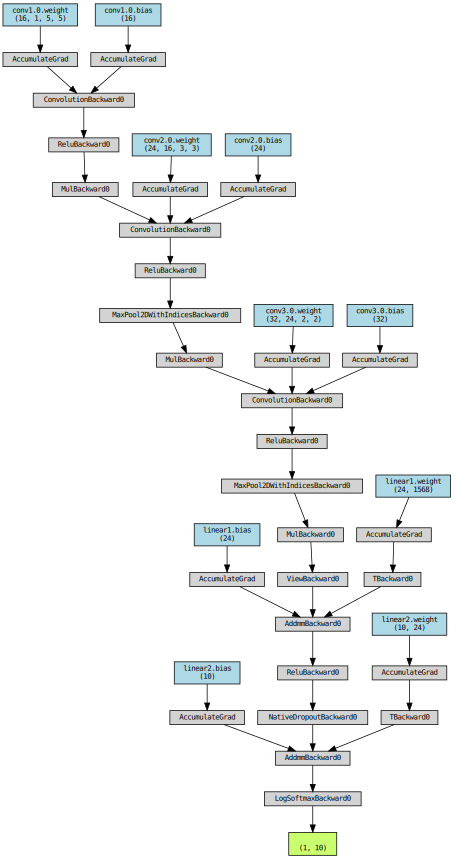

In [12]:
# %%capture
#!pip install torchviz

import torch
from torchviz import make_dot


dummy_input = torch.randn(1, 1, 28, 28).to(device)

dot = make_dot(Cnet(dummy_input), params=dict(Cnet.named_parameters()))

dot.render("CNN_visualization", format="png")

dot

## updated training


In [20]:
import os
# os.environ["OMP_NUM_THREADS"] = "1"

# Now import JAX
import jax

def train(model, loaders =loaders , num_epochs=20, loss_func = loss_func, optimizer = optimizer):

    model.train()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(loaders['train']):
            b_x = images.requires_grad_(True).to(device)
            b_y = labels.to(device)

            output = model(b_x)
            loss = loss_func(output, b_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(output.data, 1)
            total_train += b_y.size(0)
            correct_train += (predicted_train == b_y).sum().item()

        train_loss = running_loss / len(loaders['train'])
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in loaders['valid']:
                b_x = images.requires_grad_(False).to(device)
                b_y = labels.to(device)

                output = model(b_x)
                loss = loss_func(output, b_y)
                val_loss += loss.item()

                _, predicted_val = torch.max(output.data, 1)
                total_val += b_y.size(0)
                correct_val += (predicted_val == b_y).sum().item()

        val_loss /= len(loaders['valid'])
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


Epoch [1/5], Train Loss: 0.9786, Train Accuracy: 66.14%, Val Loss: 0.2963, Val Accuracy: 91.67%
Epoch [2/5], Train Loss: 0.1761, Train Accuracy: 94.70%, Val Loss: 0.1424, Val Accuracy: 95.67%
Epoch [3/5], Train Loss: 0.1331, Train Accuracy: 95.95%, Val Loss: 0.1144, Val Accuracy: 96.49%
Epoch [4/5], Train Loss: 0.1193, Train Accuracy: 96.44%, Val Loss: 0.1167, Val Accuracy: 96.38%
Epoch [5/5], Train Loss: 0.1136, Train Accuracy: 96.45%, Val Loss: 0.1113, Val Accuracy: 96.60%


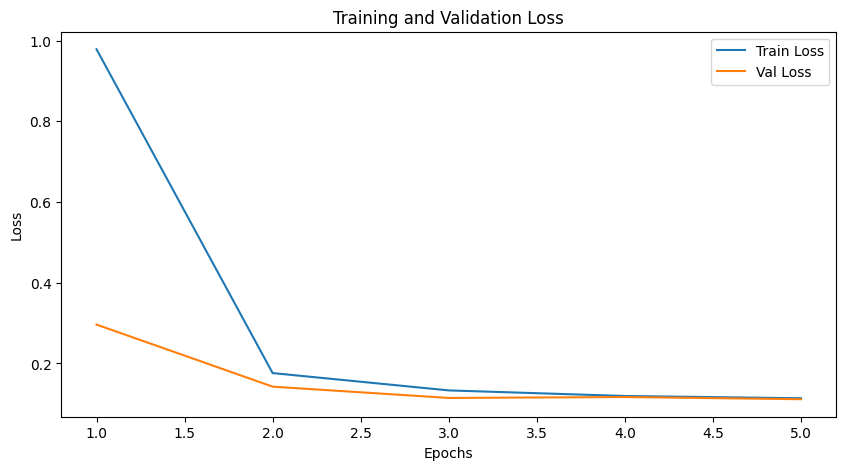

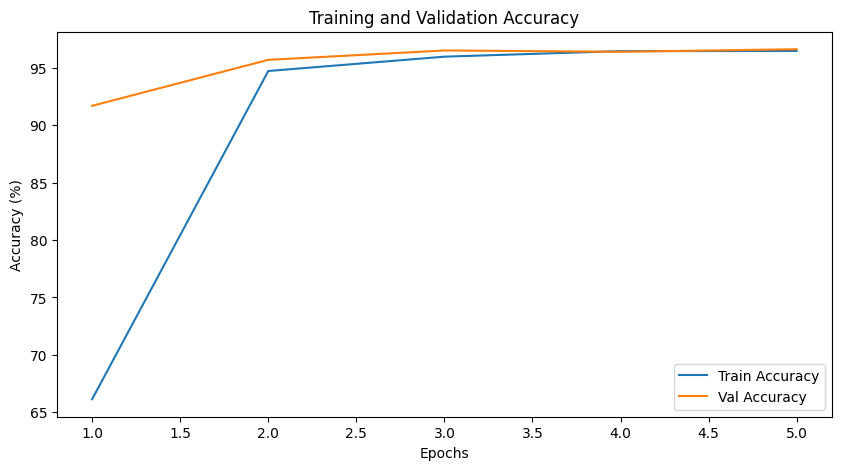

In [33]:
from torch import optim

learning_rate = 0.01

momentum = 0.9

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
#optimizer =torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

loss_func = nn.CrossEntropyLoss()

train(model, num_epochs = 5, optimizer = optimizer)

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
torch.save(model, "My_Net_trained_model.pt")

!cp  My_Net_trained_model.pt /content/drive/MyDrive/Sxoli/EFREMIDIS

model = torch.load('/content/drive/MyDrive/Sxoli/EFREMIDIS/My_Net_trained_model.pt')

<ipython-input-36-7d69479ac06c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Sxoli/EFREMIDIS/My_Net_trained_model.pt')


## test

In [38]:
def test(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for images, labels in loaders['test']:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    pass

test(model)

Test Accuracy of the model on the 10000 test images: 0.99


In [37]:
from sklearn.metrics import confusion_matrix

def test(cnn, loaders):
    model.eval()
    with torch.no_grad():
        all_predicted_labels = []
        all_true_labels = []

        for images, labels in loaders['test']:
          # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            all_predicted_labels.extend(pred_y.tolist())
            all_true_labels.extend(labels.tolist())

        # Calculate Test Accuracy
        accuracy = (torch.tensor(all_predicted_labels) == torch.tensor(all_true_labels)).float().mean().item()
        print('Test Accuracy of the model on the test set: %.2f' % accuracy)

        # Calculate Confusion Matrix
        cm = confusion_matrix(all_true_labels, all_predicted_labels)
        print('Confusion Matrix:\n', cm)

        # Calculate accuracy for each class
        class_accuracies = np.diag(cm) / cm.sum(axis=1)
        for i, acc in enumerate(class_accuracies):
            print(f'Accuracy for class {i}: {acc:.2f}')

        # Visualize wrongly predicted images
        #visualize_wrong_predictions(images, all_predicted_labels, all_true_labels)

    return all_predicted_labels, all_true_labels

all_predicted_labels, all_true_labels = test(model, loaders)


Test Accuracy of the model on the test set: 0.98
Confusion Matrix:
 [[ 968    0    1    0    0    0    9    2    0    0]
 [   1 1128    4    0    0    0    2    0    0    0]
 [   7    0 1017    1    0    0    2    4    1    0]
 [   1    0    2  988    0   10    0    5    4    0]
 [   1    0    0    0  960    0    4    3    0   14]
 [   0    0    1    3    0  885    1    1    1    0]
 [   2    2    0    0    0    5  947    0    1    1]
 [   0    5    9    1    0    0    0 1008    1    4]
 [  10    0    3    4    2    4    5    2  937    7]
 [   3    0    0    0   11    2    0    9    3  981]]
Accuracy for class 0: 0.99
Accuracy for class 1: 0.99
Accuracy for class 2: 0.99
Accuracy for class 3: 0.98
Accuracy for class 4: 0.98
Accuracy for class 5: 0.99
Accuracy for class 6: 0.99
Accuracy for class 7: 0.98
Accuracy for class 8: 0.96
Accuracy for class 9: 0.97


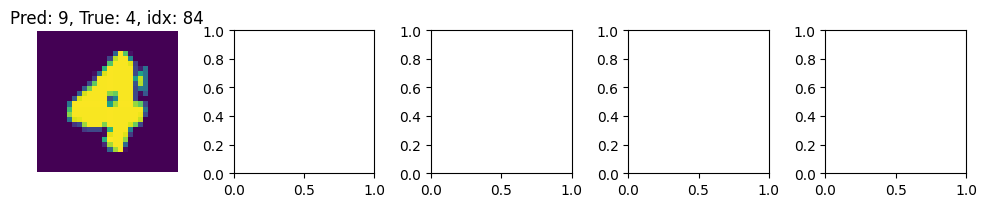

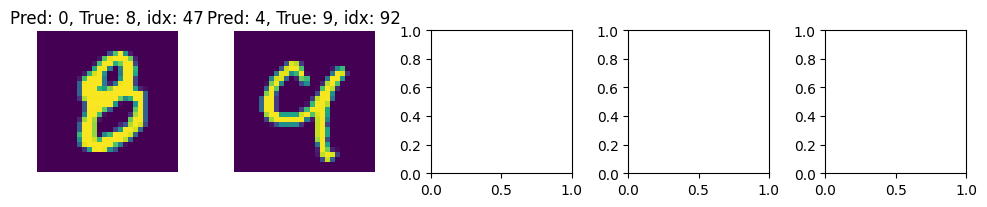

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

In [41]:
import math

def wrong_images():
    model.eval()
    with torch.no_grad():
        wrong_sum = 0

        for images, labels in loaders['test']:
            # Move images and labels to the same device as the model
            images, labels = images.to(device), labels.to(device)

            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            wrong_indices = (pred_y != labels).nonzero(as_tuple=True)[0]
            wrong_indices = wrong_indices[:20]

            wrong_sum += len(wrong_indices)

            num_samples = min(20, len(wrong_indices))
            row_len = 5
            num_rows = math.ceil(num_samples / row_len)
            fig, axes = plt.subplots(num_rows, row_len, figsize=(10, num_rows * 2))
            fig.tight_layout(pad=1.0)

            for i, idx in enumerate(wrong_indices):
                row = i // row_len
                col = i % row_len
                ax = axes[row, col] if num_rows > 1 else axes[col]

                wrong_image = images[idx].cpu().permute(1, 2, 0)
                wrong_predicted_label = pred_y[idx].item()
                wrong_true_label = labels[idx].item()

                # Plot the wrong image
                ax.imshow(wrong_image)
                ax.set_title(f'Pred: {wrong_predicted_label}, True: {wrong_true_label}, idx: {idx}')
                ax.axis('off')

            plt.show()

        print(f'Total number of wrong predictions: {wrong_sum}')

wrong_images()
